In [1]:
import sys
sys.path.append('..\\helpers')

import numpy as np
import skimage.segmentation as seg
import skimage.color as color
import skimage.io as io
import cv2
import os
import math
from morphological_sifter import MorphologicalSifter
from display import plot_figures, read_img, convert_16_to_8_bit
from feature_extractor import FeatureExtractor

from skimage.segmentation import slic, felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

mms = MorphologicalSifter()
fe = FeatureExtractor()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

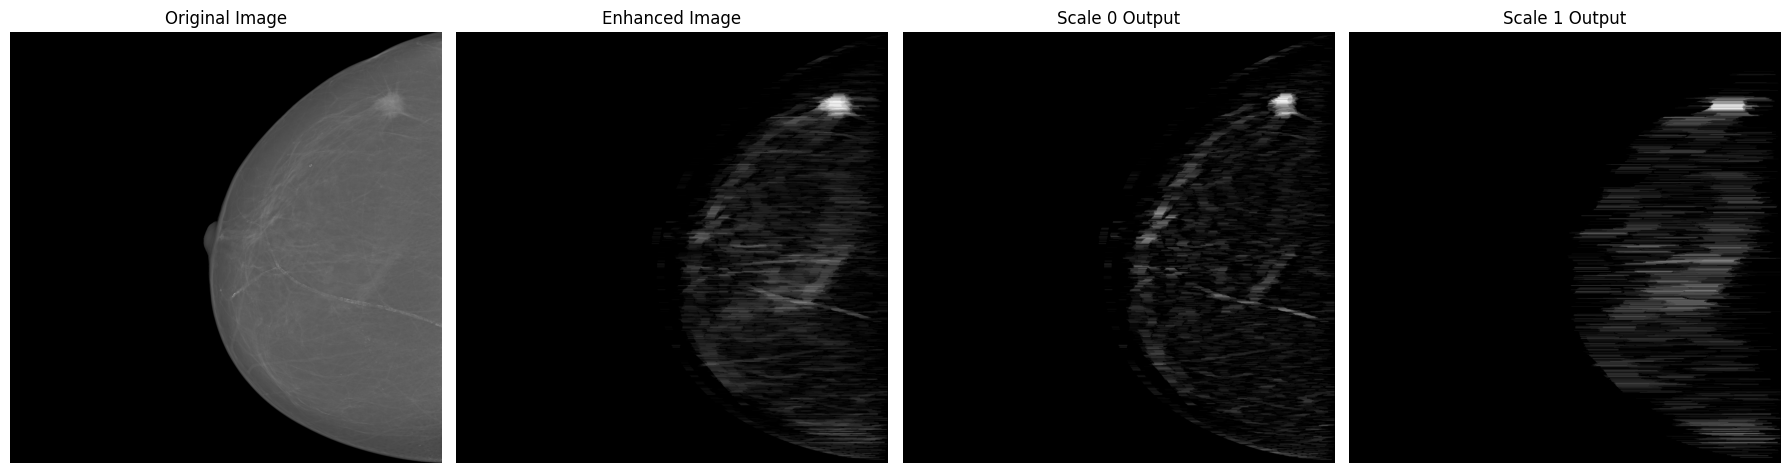

In [2]:
image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# image_input_name = '22670278_98429c0bdf78c0c7_MG_R_CC_ANON.tif'
# image_input_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'

normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
    image_input_name, 
    plot=True,
)

In [25]:
# # _, binary_img = cv2.threshold(normalized_image, thresh=15000, maxval=65535, type=cv2.THRESH_BINARY)
# _, binary_img = cv2.threshold(normalized_image, 10000, maxval=65535, type=cv2.THRESH_BINARY)

# # Define the structuring element for erosion and dilation
# # kernel = np.ones((7, 7), np.uint16)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))


# # Perform erosion and dilation
# eroded_img = cv2.erode(binary_img, kernel, iterations=1)
# dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

# img = {
#     "binary": binary_img,
#     "eroded_img": eroded_img,
#     "dilated_img": dilated_img
# }

# plot_figures(img, 1,3)

In [10]:
# import matplotlib.pyplot as plt

# image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'


# area_min = 15
# area_max = 3689

# gt_img = read_img("groundtruth", image_input_name)
# normalized_image, enhanced_images, LSE_magnitudes = mms.fit(
#     image_input_name, 
#     plot=False,
# )

# Number_pixels = normalized_image.shape[0] * normalized_image.shape[1] * 0.07 
# Number_pixels = 4 * Number_pixels

# DImin =   (math.sqrt(area_min/math.pi))  #Calculate the minimum diameter
# DImax =  (math.sqrt(area_max/math.pi))  #Calculate the maximum diameter

# S = [ 12,  20,  36, 62]
# Number_k = (np.divide(Number_pixels,(np.multiply(S,S)))).astype(np.int32)

# contours, hierarchy = cv2.findContours(gt_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# seg = len(contours)
# mask = np.zeros([seg,gt_img.shape[0],gt_img.shape[1]] ,np.uint8)
# for i in range(seg):
#     cv2.drawContours(mask[i,:,:], [contours[i]], -1, (255, 0, 0), 9)


# # combine all the masks into one
# combined_mask = np.sum(mask, axis=0)


# # plot the mask using matplotlib
# plt.imshow(combined_mask, cmap='gray')
# plt.axis('off')
# plt.show()


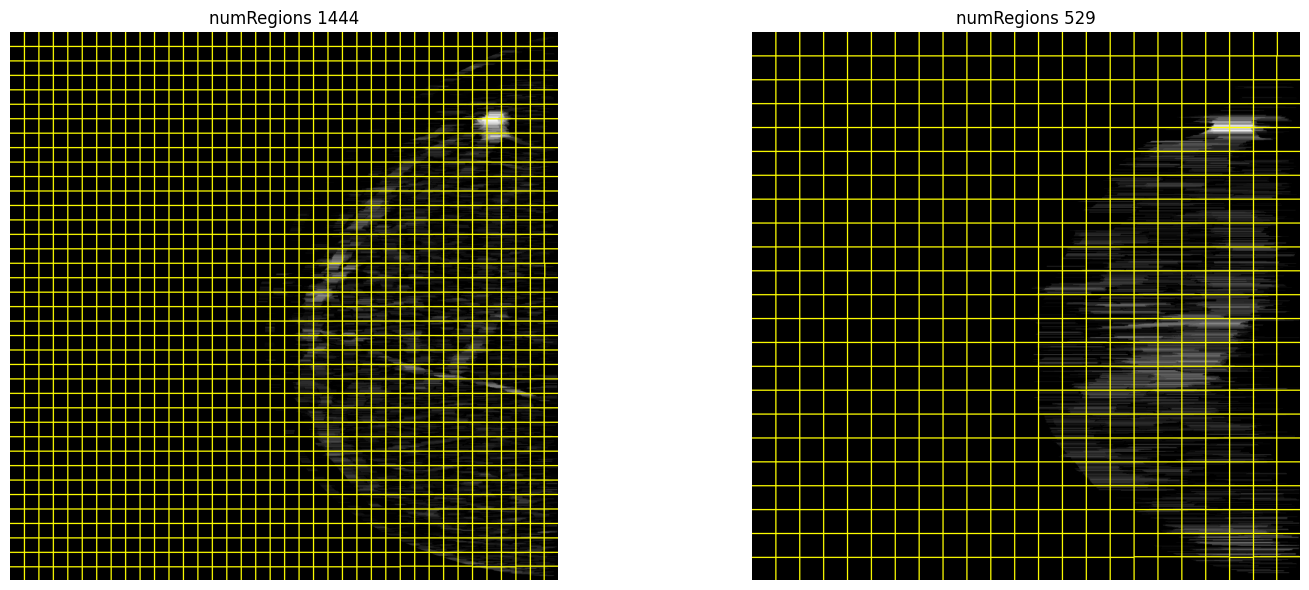

In [3]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

Number_pixels = normalized_image.shape[0] * normalized_image.shape[1] * 0.07 
Number_pixels = 4 * Number_pixels

S = [ 12,  20,  36, 62]
Number_k = (np.divide(Number_pixels,(np.multiply(S,S)))).astype(np.int32)

_, enhanced_images, _ = mms.fit(
    image_input_name, 
    plot=False,
)

# apply SLIC and extract (approximately) the supplied number
# of segments
for i in range(len(enhanced_images)):
    img_thresh=enhanced_images[i].astype(float)

    numSegments=Number_k[i]
    sigma1 = 5
    compact=10000
    
    if i == 3:
        sigma1=20
        compact=8000
        
    segments = slic(img_thresh, 
                    n_segments = numSegments,
                    enforce_connectivity=True, 
                    compactness=compact, 
                    sigma=sigma1, 
                    channel_axis=None
                   )
#     img_thresh_old = img_thresh
#     img_thresh = img_thresh/65535
#     segments = felzenszwalb(img_thresh, scale=3689, min_size=15,sigma=3)
    
    numRegions = segments.max()
    
    # show the output of SLIC
    ax[i].imshow(mark_boundaries(enhanced_images[i], segments))
    ax[i].set_title(f"numRegions {numRegions}")
    ax[i].set_axis_off()

plt.tight_layout()

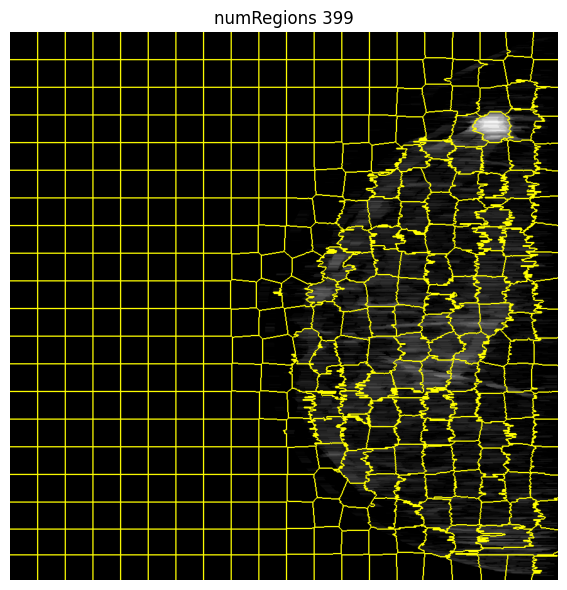

In [53]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 6))

normalized_image,_ ,_ = mms.fit(
    image_input_name, 
    plot=False,
)

# load the image and convert it to a floating point data type
image = normalized_image.copy()

# apply SLIC and extract (approximately) the supplied number
# of segments
# img_thresh=image.astype(float)

segments = slic(image, 
                n_segments=400,
#                 enforce_connectivity=True, 
                compactness=0.1, 
#                 sigma=0.3,
                channel_axis=None,
                slic_zero = True
               )

numRegions = segments.max()

# show the output of SLIC
ax.imshow(mark_boundaries(image, segments))
ax.set_title(f"numRegions {numRegions}")
ax.set_axis_off()

plt.tight_layout()

### Feature Extraction

In [5]:
image = convert_16_to_8_bit(image)

print(image.dtype, image.max())

uint8 255


In [6]:
# Extract features from superpixels
texture_features = fe.extract_texture_features(image)
shape_features = fe.extract_shape_features(image, segments)
intensity_features = fe.extract_intensity_features(image, segments)

In [7]:
texture_features

array([ 43.39434314, 130.93519158, 106.9145006 , 122.09275836,
       103.88938612, 130.93519158, 205.27881773, 122.09275836,
       170.28985808, 249.41223266, 275.44043867, 224.89467106,
         2.87424816,   6.82144337,   6.20571295,   6.60843405,
         5.22761973,   6.82144337,   8.55049142,   6.60843405,
         7.35847907,   9.40560375,   9.92385289,   9.01287786,
         0.69302642,   0.41797718,   0.42996991,   0.42158224,
         0.54303235,   0.41797718,   0.3945295 ,   0.42158224,
         0.43174112,   0.38151278,   0.3779046 ,   0.38723359,
         0.34404419,   0.31747752,   0.32333204,   0.31888885,
         0.32433641,   0.31747752,   0.31232585,   0.31888885,
         0.31094199,   0.30533509,   0.3065843 ,   0.30732151,
         0.95879421,   0.87571539,   0.89844677,   0.88410869,
         0.90140403,   0.87571539,   0.80508961,   0.88410869,
         0.83846508,   0.7634748 ,   0.73857322,   0.78672555])

In [8]:
shape_features

array([4.45153500e+07, 1.06566926e+15, 2.57891960e+17, ...,
       1.41383107e+56, 1.35029778e+39, 4.94484866e+47])

In [9]:
intensity_features

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [14.40993789, 25.30987386],
       [18.71635611, 24.69650736],
       [21.69565217, 21.84598171]])